In [4]:
import torch, torchvision
from torch import nn
import torch.nn.functional as F
from torch import optim
from torchvision import datasets, transforms
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,)),
                              ])
# Download and load the training data
trainset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the test data
testset = datasets.MNIST('MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

In [3]:
class Network(nn.Module):
    
    def __init__(self, input_size, output_size, hidden_layers, drop_p=0.05):
        ''' Builds a feedforward network with arbitrary hidden layers.
        
            Arguments
            ---------
            input_size: integer, size of input
            output_size: integer, size of output layer
            hidden_layers: list of integers, the sizes of the hidden layers
            drop_p: float between 0 and 1, dropout probability
        '''
        
        super().__init__()
        # Add the first layer, input to a hidden layer
        self.hidden_layers = nn.ModuleList([nn.Linear(input_size, hidden_layers[0])])
        
        # Add a variable number of more hidden layers
        layer_sizes = zip(hidden_layers[:-1], hidden_layers[1:])
        self.hidden_layers.extend([nn.Linear(h1, h2) for h1, h2 in layer_sizes])
        
        self.output = nn.Linear(hidden_layers[-1], output_size)
        
        self.dropout = nn.Dropout(p=drop_p)
    
    
    def forward(self, x):
        ''' Forward pass through the network, returns the output logits'''
        
        # Forwardc through each layer in `hidden_layers`, with ReLU activation and dropout
        for linear in self.hidden_layers:
            x = F.relu(linear(x))
            x.dropout = self.dropout(x)
        
        x = self.output(x)
        
        return F.log_softmax(x, dim=1)

In [5]:
# create tghe network, define the criterion and optimizer
model = Network(input_size=784, output_size=10, hidden_layers=[516, 256])
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [6]:
# The validation function
def validation(model, testloader, criterion):
    test_loss = 0
    accuracy = 0
    for images, labels in testloader:
        images.resize_(images.shape[0], 784)
        output = model.forward(images)
        test_loss += criterion(output, labels).item()
        ps = torch.exp(output)
        equality = (labels.data == ps.max(dim=1)[1])
        accuracy += equality.type(torch.FloatTensor).mean()
        
    return test_loss, accuracy

#### Training the model

In [7]:
epochs = 2
steps = 0
running_loss = 0
print_every = 40
for e in range(epochs):
    model.train()
    for images, labels in trainloader:
        steps += 1
        # Flatten images into a 784 long vector
        images.resize_(images.size()[0], 784)
        optimizer.zero_grad()
        output = model.forward(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if steps % print_every == 0:
            model.eval()
            with torch.no_grad():
                test_loss, accuracy = validation(model, testloader, criterion)
            print('Epochs: {}/{}..'.format(e+1, epochs),
                  'Training Loss: {:.4f}..'.format(running_loss/print_every),
                  'Test Loss: {:.4f}..'.format(test_loss/len(testloader)),
                  'Test Accuracy: {:.4f}'.format(accuracy/len(testloader)))
            running_loss = 0
            model.train()

Epochs: 1/2.. Training Loss: 1.1600.. Test Loss: 0.5571.. Test Accuracy: 0.8182
Epochs: 1/2.. Training Loss: 0.5355.. Test Loss: 0.4948.. Test Accuracy: 0.8522
Epochs: 1/2.. Training Loss: 0.4106.. Test Loss: 0.3801.. Test Accuracy: 0.8800
Epochs: 1/2.. Training Loss: 0.3936.. Test Loss: 0.3425.. Test Accuracy: 0.9013
Epochs: 1/2.. Training Loss: 0.3342.. Test Loss: 0.3096.. Test Accuracy: 0.9052
Epochs: 1/2.. Training Loss: 0.3255.. Test Loss: 0.3038.. Test Accuracy: 0.9069
Epochs: 1/2.. Training Loss: 0.3039.. Test Loss: 0.2811.. Test Accuracy: 0.9138
Epochs: 1/2.. Training Loss: 0.3291.. Test Loss: 0.3041.. Test Accuracy: 0.8993
Epochs: 1/2.. Training Loss: 0.2906.. Test Loss: 0.2412.. Test Accuracy: 0.9258
Epochs: 1/2.. Training Loss: 0.2490.. Test Loss: 0.2378.. Test Accuracy: 0.9299
Epochs: 1/2.. Training Loss: 0.2268.. Test Loss: 0.2249.. Test Accuracy: 0.9335
Epochs: 1/2.. Training Loss: 0.2542.. Test Loss: 0.2292.. Test Accuracy: 0.9280
Epochs: 1/2.. Training Loss: 0.2629.. Te

#### Inference

In [9]:
def view_classify(img, ps, version="MNIST"):
    ''' Function for viewing an image and it's predicted classes.
    '''
    ps = ps.data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    if version == "MNIST":
        ax2.set_yticklabels(np.arange(10))
    elif version == "Fashion":
        ax2.set_yticklabels(['T-shirt/top',
                            'Trouser',
                            'Pullover',
                            'Dress',
                            'Coat',
                            'Sandal',
                            'Shirt',
                            'Sneaker',
                            'Bag',
                            'Ankle Boot'], size='small');
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)



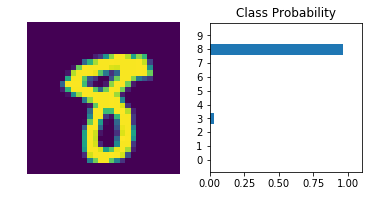

In [15]:
model.eval()

dataiter = iter(testloader)
images, labels = dataiter.next()
img = images[3]
# Convert 2D image to 1D vector
img = img.view(1, 784)

# Calculate the class probabilities (softmax) for img
with torch.no_grad():
    output = model.forward(img)

ps = torch.exp(output)
view_classify(img.view(1, 28, 28), ps, version='MNIST')